**Описание проекта**


Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.


В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».
Инструкция по выполнению проекта


<b><font size=3>1. Импорт библиотек, чтение файла</font></b><a name="1"></a><br/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Для удобства скинем названия столбцов в нижний регистр:

In [4]:
games.columns = games.columns.str.lower()

In [5]:
games.head() #проверим

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<b><font size=3>2. Подготовка данных</font></b><a name="2"></a><br/>

**2.1 Заполнение пропусков и изменение типов данных**

Есть пропуски, посмотрим .info()

In [6]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В столбце **user_score** видны **текстовые значения**, в таблице gamse.head() в этом столбце мы наблюдаем же **числа**

Посмотрим на процент пропусков. Напишем функцию:

In [7]:
def percent_of_nan(df):
    nan_sum = df.isnull().sum(axis = 0).sort_values(ascending = False)
    nan_percent = (nan_sum / len(df))*100
    nan_percen_mean = nan_percent.mean()
    new_frame = {'Число пропусков': nan_sum, 'Процент пропусков': nan_percent }
    dataframe = pd.DataFrame(new_frame).sort_values(by = 'Процент пропусков', ascending = False).round(2)
    return dataframe, print('Средний процент пропусков', nan_percen_mean.round(2))

In [8]:
percent_of_nan(games)

Средний процент пропусков 12.14


(                 Число пропусков  Процент пропусков
 critic_score                8578              51.32
 rating                      6766              40.48
 user_score                  6701              40.09
 year_of_release              269               1.61
 genre                          2               0.01
 name                           2               0.01
 other_sales                    0               0.00
 jp_sales                       0               0.00
 eu_sales                       0               0.00
 na_sales                       0               0.00
 platform                       0               0.00,
 None)

Что делаем:

**сritic_score** -  возможно, на заре игровой индустрии игры никто не критиковал. Ставить среднее значение нецелесообразно, даже при категоризации по жанрам. Надо проверить, есть ли игры с рейтингом 0, если нет, то можем заментить рейтинг на нули, если нету, то на -1, чтобы не смешивать с играми с нулевым рейтингом

**user_score** - логика, аналогичная **сritic_score**

**rating** - Столбец текстовый. Логично, что организация ESRB появилась позже первой игры. Оставим.

Проверим на наличие нулей:

In [9]:
games['critic_score'].value_counts()

70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
       ... 
20.0      3
17.0      1
22.0      1
13.0      1
21.0      1
Name: critic_score, Length: 82, dtype: int64

In [10]:
games[games['critic_score'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Нулевых значений в столбце **critic_score** нет

In [11]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.6       2
1.9       2
1         2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Один нулевой рейтнг в столбце **user_score** все же есть. Так же видно загадочную аббривеатуру **tdb**. Так как это рейтинг игроков, сделаем предположение, что **tdb** - это игры без рейтинга пользователей, возможно игры, в которые никто не играет, фактически это NaN.

Так как столбец **user_score** это object, посмотрим все уникальные значения, вдруг еще есть аббривеатуры

In [12]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Аббривеатура одна. Заменим **tdb** на NaN и заменим тип данного столбца с рейтингом:

In [13]:
games['user_score'] = games['user_score'].replace('tbd', np.NaN)
games['user_score'] = games['user_score'].astype('float')

**2.2 Обработка пропусков**

Мы нашли рейтинг '0' в  столбце **user_score**. Заполним NaN значением '-1'. Столбец **critic_score** сделаем по аналогии, хоть там и нет пропусков.

In [14]:
games['critic_score'] = games['critic_score'].fillna(-1)
games['user_score'] = games['user_score'].fillna(-1)
games['rating'] = games['rating'].fillna('No ESRB')  #вернул no-esrb

print('Количество пропусков в столбце critic_score - {}'.format(games['critic_score'].isnull().sum()))
print('Количество пропусков в столбце user_score - {}'.format(games['user_score'].isnull().sum()))
print('Количество пропусков в столбце rating - {}'.format(games['rating'].isnull().sum()))

Количество пропусков в столбце critic_score - 0
Количество пропусков в столбце user_score - 0
Количество пропусков в столбце rating - 0


In [15]:
year_median = games['year_of_release'].median()
games['year_of_release'] = games['year_of_release'].fillna(value = year_median)
games['year_of_release'] = games['year_of_release'].astype('int16')#год заполнил медианой
print('Количество пропусков в столбце year_of_release - {}'.format(games['year_of_release'].isnull().sum()))

Количество пропусков в столбце year_of_release - 0


Создадим стольец с общей суммой

In [16]:
games['sales_total'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Посмотри на результат:

In [17]:
percent_of_nan(games)

Средний процент пропусков 0.0


(                 Число пропусков  Процент пропусков
 genre                          2               0.01
 name                           2               0.01
 sales_total                    0               0.00
 rating                         0               0.00
 user_score                     0               0.00
 critic_score                   0               0.00
 other_sales                    0               0.00
 jp_sales                       0               0.00
 eu_sales                       0               0.00
 na_sales                       0               0.00
 year_of_release                0               0.00
 platform                       0               0.00,
 None)

**2.3 Посмотрим на столбцы с низким процентом пропусков**

Столбцы **years_of_release**, **genre** и **name** трогать не будем, число пропусков слишком мало. Оставим как есть

**3. Исследовательский анализ данных**

**3.1 Функция для bar - графиков**

In [18]:
def bar(groupby_column, func, y='name'):
    plt.style.use('bmh')
    plt.ylabel('quantity')
    plt.title('distribution histogram')
    df_to_plot = games.groupby(groupby_column)[y]
    if func == 'count':
        df_to_plot_calc = df_to_plot.count()
        figsize = (15,5)
        plot = df_to_plot_calc.plot(kind='bar', y=y, figsize=figsize, ec='black', grid = 'True',  color = 'r')
        
    elif func == 'sum':
        df_to_plot_calc = df_to_plot.sum().sort_values()
        figsize = (15,5)
        plot = df_to_plot_calc.plot(kind='bar', y=y, figsize=figsize, ec='black', grid = 'True')

**3.2 Распределение количества выпущенных игр по годам**

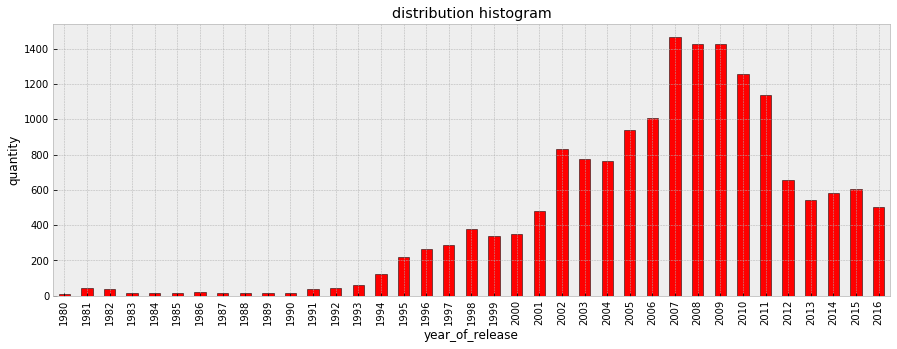

In [19]:
bar('year_of_release', 'count')

Пик производства игр пришелся на 2008-2009 года, Заменто, что количественный скачек произошел в 1994 году. Кажется именно тогда появился процессор Pentium и PC - платформы пошли в массы.

**3.3 Количество выпущенных игр по платформам**

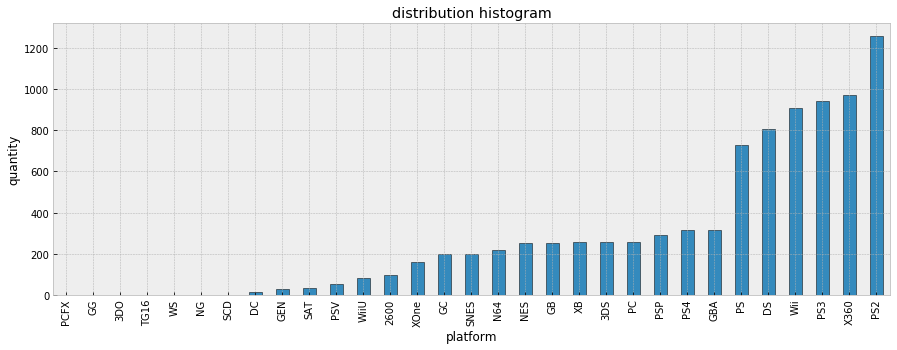

In [20]:
bar('platform', 'sum', 'sales_total')

Sony Play Station - безусловный лидер в производстве игр для приставок. 3 поколения коносолей - в топ-6. Топ-6 вырисовывается довольно отчётливо.

**3.4 Динамика продаж игр по платформам**

Найдем топ-10 платформ с наибольшим числом продаж за все время:

In [21]:
games.groupby('platform')['sales_total'].sum().to_frame('sales_total').sort_values(by='sales_total', ascending=False).head(10).T

platform,PS2,X360,PS3,Wii,DS,PS,GBA,PS4,PSP,PC
sales_total,1255.77,971.42,939.65,907.51,806.12,730.86,317.85,314.14,294.05,259.52


Отрисуем динамику продаж по топ-10:

In [22]:
top_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PSP', 'PC', 'PS4']

In [23]:
top_10_platforms = games.query("platform == @top_platforms").pivot_table(index = 'year_of_release', columns = 'platform',
                                    values = 'sales_total', aggfunc = 'sum')

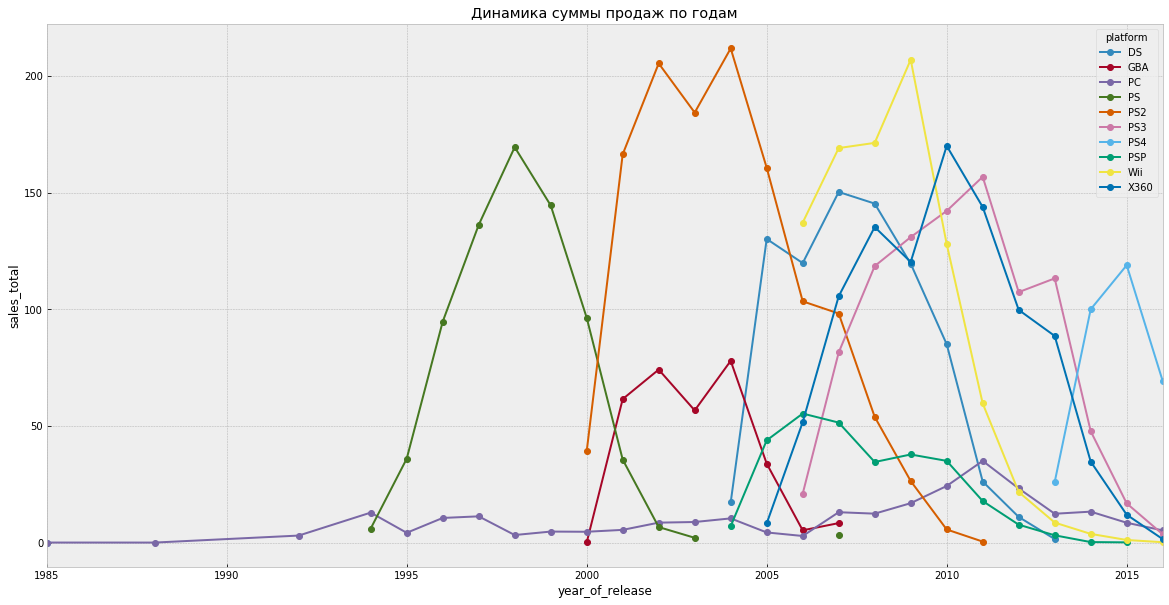

In [24]:
fig, ax = plt.subplots()
top_10_platforms.plot(kind='line', figsize=(20,10), title='Динамика суммы продаж по годам',ax=ax, style ='o-');
ax.set_ylabel('sales_total');

За исключением PC, срок активной жизни конслоей составляет порядка 10 лет. Прогресс и технологии не стоят на месте

**3.5 Динамика продаж игр по платформам по выбранному интервалу:**

Сделаем выборку с 2006 по 2016 года. Самые популярные консоли находятся в этом интервале. А так же данные по всем консолям есть

Построим ещё один график, отображающий динамику продаж по уже актуальным годам и ответим на вопрос:
Какие платформы лидируют по продажам, растут или падают?

Затем выберем платфомы для дальнейшего анализа.

In [25]:
top_platforms_2006 = games.query("year_of_release>2005").pivot_table(index = 'year_of_release', columns = 'platform',
                                                                         values = 'sales_total', aggfunc = 'sum')

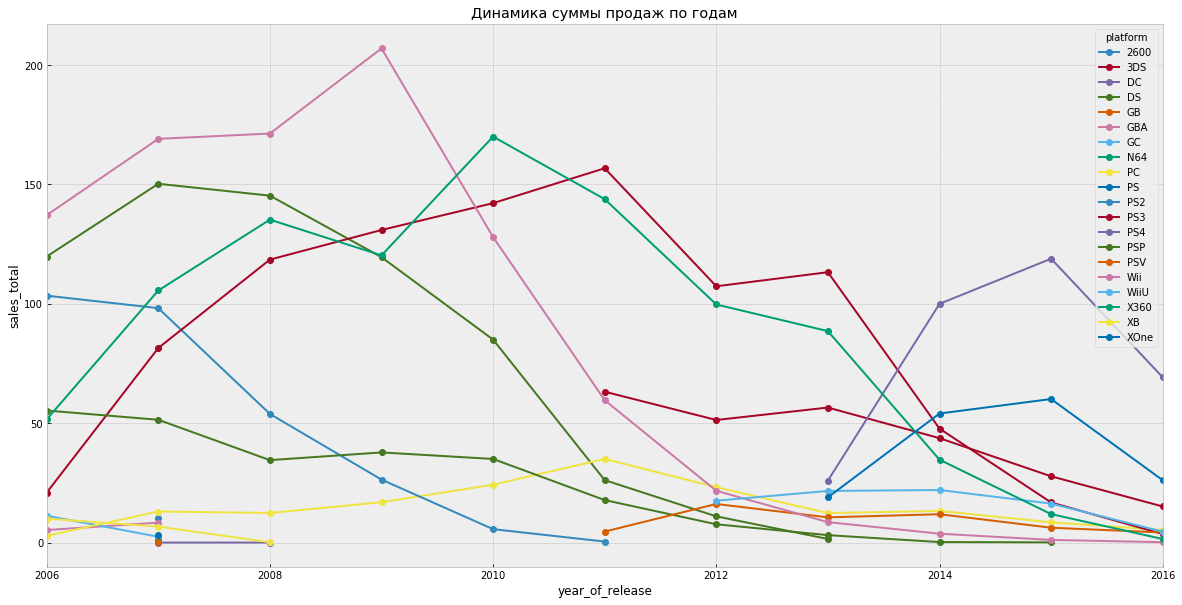

In [26]:
fig, ax = plt.subplots()
top_platforms_2006.plot(kind='line', figsize=(20,10), title='Динамика суммы продаж по годам', ax=ax, style ='o-');
ax.set_ylabel('sales_total');

На конец 2016 года можно выделить  платформы: PS3, X360, DS, Wii и новую PS4. Динамика отрицательная, видно что рынок падает, Даже у новинки PS4

**3.6. Boxplot по продажам игр  с разбивкой по платформам**

In [27]:
def boxplot(title=None, query = None, ylims=None):
    if query == None:
        ax = games.boxplot(column='sales_total', fontsize=20, figsize=(20,10),
                                         boxprops=dict(linestyle='-', linewidth=3),
                                         medianprops=dict(linestyle='-', linewidth=3),
                                         whiskerprops=dict(linestyle='-', linewidth=3),
                                         capprops=dict(linestyle='-', linewidth=3), 
                                         notch=True)
    else:
        df_query = games.query(query)
        by_column = query.split()[0]
        ax = df_query.boxplot(column='sales_total', by=by_column, fontsize=20, figsize=(20,10),
                                         boxprops=dict(linestyle='-', linewidth=3),
                                         medianprops=dict(linestyle='-', linewidth=3),
                                         whiskerprops=dict(linestyle='-', linewidth=3),
                                         capprops=dict(linestyle='-', linewidth=3),
                                         notch=True)
        ax.set_xlabel('')
        ax.set_title('')
    if ylims != None:
        ax.set_ylim(ylims)
    if title != None:
        plt.suptitle(title, y=0.9, fontsize=20)

Продажи игр - до 1,2 млн. Медиана = 0,2. Ожидал увидеть больщую сумму

**3.7 Boxplot по топ платформам**

Выберем топ платформы для анализа

In [29]:
top8_2006_2016 = ['PS2', 'X360', 'PS3', 'Wii', 'PS', 'DS', 'PS4', 'XOne']

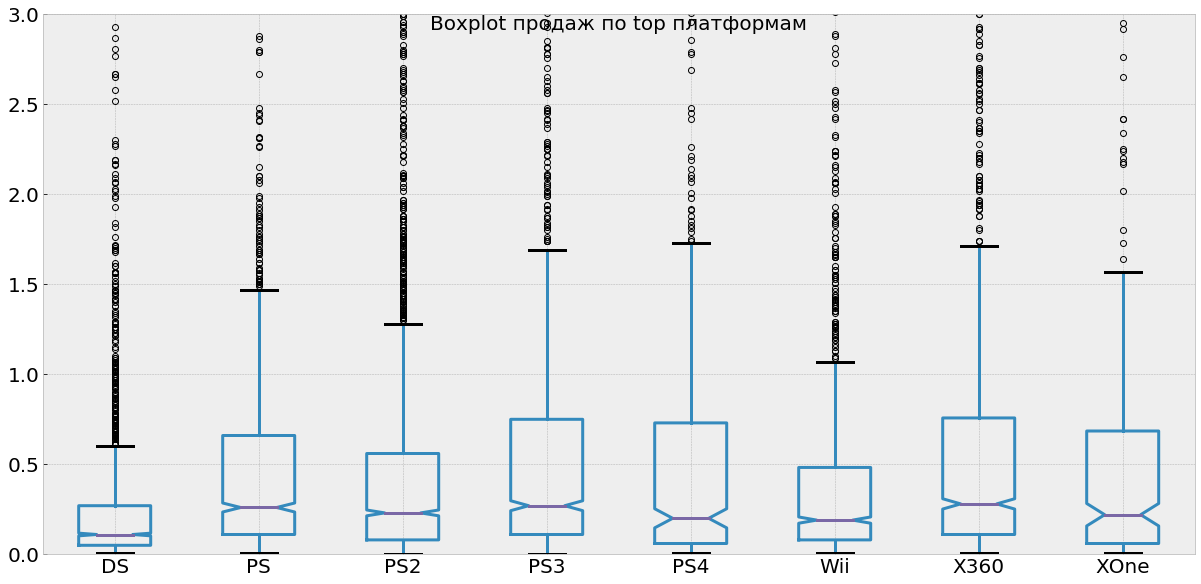

In [30]:
boxplot('Boxplot продаж по top платформам', query="platform in @top8_2006_2016", ylims = [0,3])

Медиана продаж топ платформ в диапазоне от 0,2 до 0,25. Верхняя граница предела у двух платформ - PS3 и X360 - на уровне 1,7 млн долларов.
У остальных - от 1 до 1,5 миллионов долларов.
Среди всех выделяется Nintendo DS - у него эти показатели сильное ниже. Медиана < 0,1 миллиона долларов, верхняя граница - 0,6 млн.

**3.8 Влияние отзывов пользователей и критиков на продажи.**

Посмотрим на примере PS3: топовой приставки от Sony:

In [31]:
ps3 = games[(games['platform'] == 'PS3') & (games['critic_score'] > 0) & (games['user_score'] > 0) ]

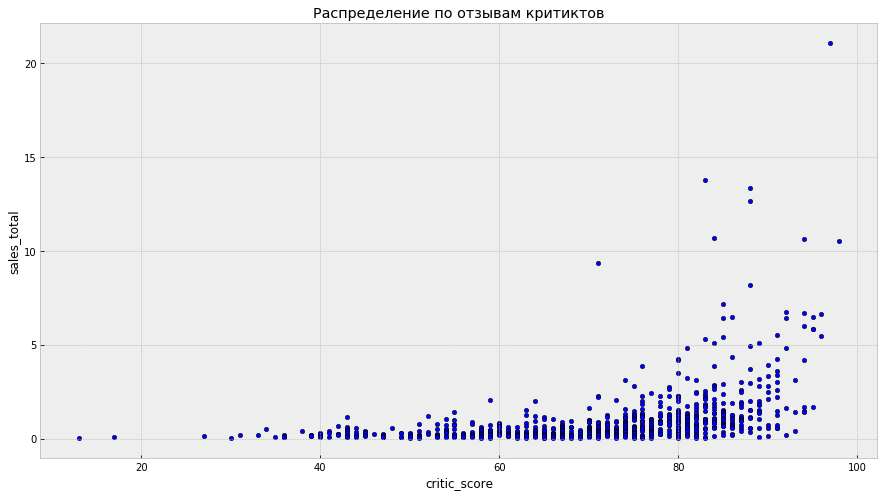

In [32]:
ps3_critic = games[(games['platform'] == 'PS3') & (games['critic_score'] > 0) & (games['user_score'] > 0)]
ps3_critic.plot(kind='scatter', x='critic_score', y='sales_total', ec='black', figsize=(15,8), title ='Распределение по отзывам критиктов');

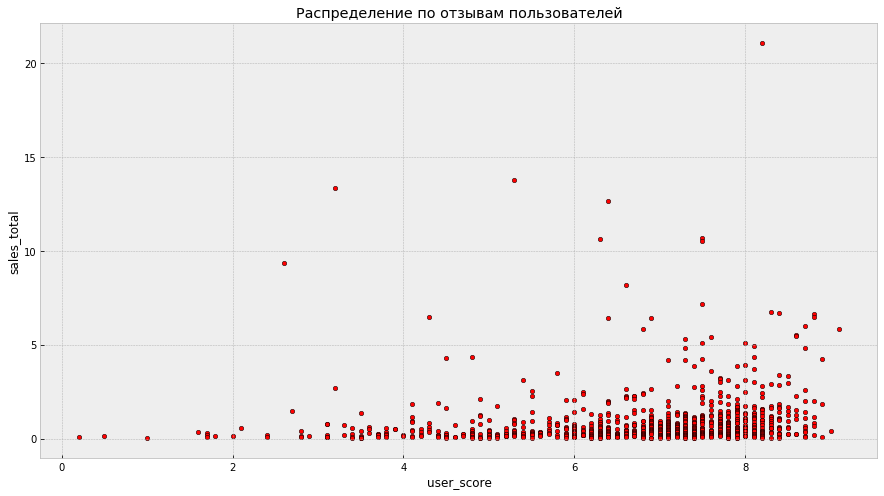

In [33]:
ps3_user = games[(games['platform'] == 'PS3') & (games['user_score'] > 0)]
ps3_user.plot(kind='scatter', x='user_score', y='sales_total', ec='black', figsize=(15,8), color ='r', title ='Распределение по отзывам пользователей' );

Критики как правило работают в СМИ (блоги, издания, сайты). СМИ - очень сильный инструмент влияния на мнение людей. Из этого логично следует, что чем выше рейтинг критиков, тем выше продажи.

Впринципе картина по пользователям похожа. Важно отметить фанатов серийных игр (FIFA, Assasin и тд), которые сначала покупают игру, а потом ставят низкую оценку, если игра серии им показалась хуже предыдущей

**3.9 Коореляция**

Составим матрицу коореляции:

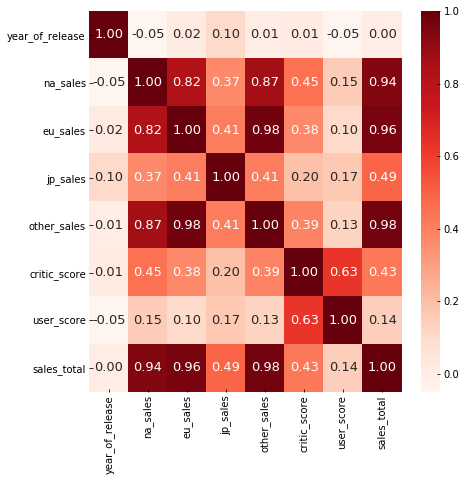

In [34]:
plt.figure(figsize=(7,7))
sns.heatmap(ps3.corr(), annot=True, cmap="Reds", fmt='.2f', annot_kws={'size':13});

Сделаем срез по отзывам критиков и пользователей:

In [35]:
ps3_filtered = ps3[['sales_total' ,'critic_score', 'user_score']]

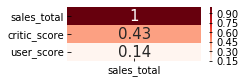

In [36]:
plt.figure(figsize=(3,1))
sns.heatmap(ps3_filtered.corr()[['sales_total']].sort_values(by='sales_total', ascending=False), cmap="Reds", annot=True, annot_kws={'size':15});

Сильнее всего на конечную стоимость влияет оценка критиков. Практически не влияет - оценка пользователей. Эти цифры подтверждают вывод о влиянии СМИ.

**3.10 Коореляция по топовым платформам в период с 2006 по 2016 год:**

<div class="alert alert-block alert-info">
<b>Fixed:</b> 
Добавил PS4 и XOne
</div>

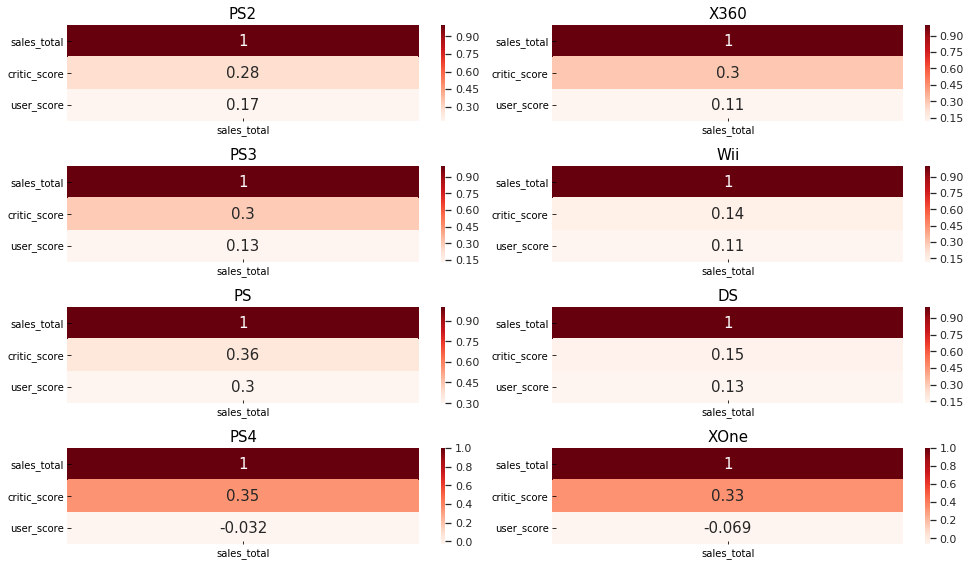

In [37]:
rows = len(top8_2006_2016) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(14,8))
count = 0
for r in range(rows):
    for c in range(cols):
        current_platform = top8_2006_2016[count]
        df_prepared = games[(games['platform'] == current_platform) & (games['user_score'] > 0)]
        
        df_filtered = df_prepared[['sales_total' ,'critic_score', 'user_score']]
        sns.set(font_scale=1.0)
        ax = sns.heatmap(df_filtered.corr()[['sales_total']].sort_values(by='sales_total', ascending=False), 
                         cmap="Reds", annot=True, annot_kws={'size':15}, ax=axes[r,c])
        ax.set_title(current_platform, fontsize=15)
        plt.tight_layout(pad=1)
        count += 1

Данные по корреляции между выручкой и оценкой по платформам PS2, X360, PS3, PS впринципе совпадает с общими данными по датафрейму.

Можно отметить, что для платформ Wii и DS зависимость не такая большая

**3.11 Распределение по жанрам**

Построим столбчатые диаграммы с количеством и суммой продаж по жанрам:

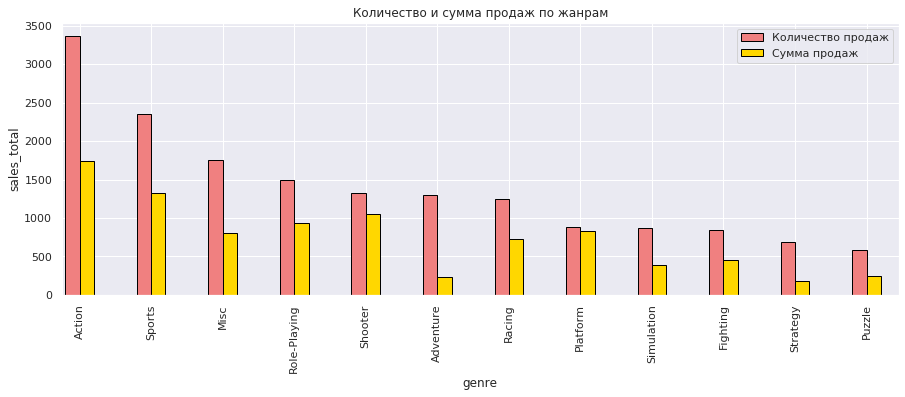

In [38]:
ax = plt.gca()

pivot = games.groupby('genre').agg({'name': 'count', 'sales_total': 'sum'}).sort_values(by='name', ascending=False)

genre = pivot['name']
genre.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color = 'lightcoral', position=1)

sales = pivot['sales_total']
sales.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color='gold', position=0)

ax.legend(['Количество продаж', 'Cумма продаж']);
ax.set_ylabel('sales_total');
ax.set_title('Количество и сумма продаж по жанрам');

Сортировка по продажам:

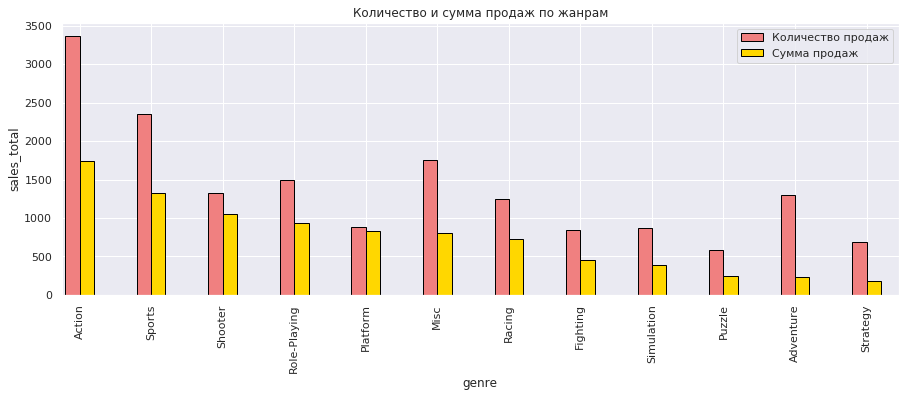

In [39]:
ax = plt.gca()

pivot = games.groupby('genre').agg({'name': 'count', 'sales_total': 'sum'}).sort_values(by='sales_total', ascending=False)

genre = pivot['name']
genre.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color = 'lightcoral', position=1)

sales = pivot['sales_total']
sales.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color='gold', position=0)

ax.legend(['Количество продаж', 'Cумма продаж']);
ax.set_ylabel('sales_total');
ax.set_title('Количество и сумма продаж по жанрам');

По количеству проданных игр топ-3 выглядит так:

1) Action


2) Sport


3) Misc

Хуже всего дела обстоят у головоломок и, что для меня неожиданно, стратегий. Хотя стратегии это больше история для РС. В нашем датафрейме в основном консоли

По количеству продаж топ-3 выглядит так:

1) Action


2) Sport


3) Shooter

Аутсайдеры: стратегии, пазлы и приключения. Уверен, что производство пазла стоит в разы дешевле чем шутера. Не хватает данных по себестоимость продукта. Однако непопулярность головоломок вполнге логична. Малко кто будет покупать мощную консоль для игры в пасьянс

In [40]:
top_genre = games.groupby('genre').agg({'sales_total': 'sum', 'genre': 'count'})
top_genre['top_sales'] = top_genre['sales_total'] / top_genre['genre']
top_genre.sort_values(by='top_sales', ascending=False).round(2)

,sales_total,genre,top_sales
genre,,,
Platform,827.77,888,0.93
Shooter,1052.45,1323,0.80
Role-Playing,934.56,1498,0.62
Racing,728.67,1249,0.58
Sports,1331.27,2348,0.57
Fighting,447.53,849,0.53
Action,1744.17,3369,0.52
Misc,802.51,1750,0.46
Simulation,389.97,873,0.45


**4. Портрет пользователя регионов NA, EU, JP**

Определим для пользователя каждого региона (NA, EU, JP):

самые популярные платформы (топ-5)


самые популярные жанры (топ-5)


определим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

**4.1 Топ-5 платформ в срезе продаж по регионам:**

In [41]:
games2006_2016 = games.query("year_of_release>2005")

In [42]:
def top_regions(groupby, region_sales, ax):
    pivot = games2006_2016.groupby(groupby).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False)[0:5]
    title_dict = {'na_sales': 'Северная Америка', 'eu_sales': 'Европа', 'jp_sales': 'Япония'}
    color_dict = {'na_sales': 'r', 'eu_sales': 'lightblue', 'jp_sales': 'floralwhite'}
    plot = pivot.plot(kind='bar', ec='black', title=title_dict[region_sales], ax=axes[ax], 
                   fontsize=18, color=color_dict[region_sales])
    plot.legend(prop={'size':15})
    plot.set_xlabel('платформа')
    plot.set_ylabel('продажи')
    plot.title.set_size(20)

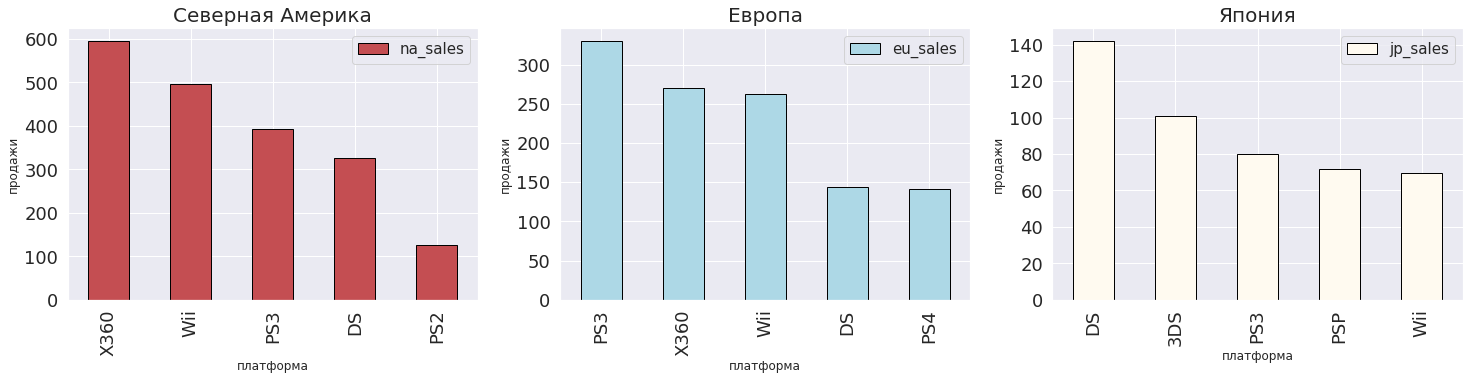

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(25,5))

top_regions('platform', 'na_sales', 0)
top_regions('platform', 'eu_sales', 1)
top_regions('platform', 'jp_sales', 2)

Северная америка: Лидер - местная платформа от Microsoft. Патриотизм в деле. Почти вровень идут Sony (jpn) со своей PS2

Европа: Топ продаж у Sony с их PS2 и PS3

Япония: Картина несколько другая, Лидер - Nintendo DS. Фактически карманная платформа. В Европе и С.Америке в лидерах декстопы. Также топ-5 в Японии представлен местными производителями.

**4.2 Топ-5 жанров по регионам:**

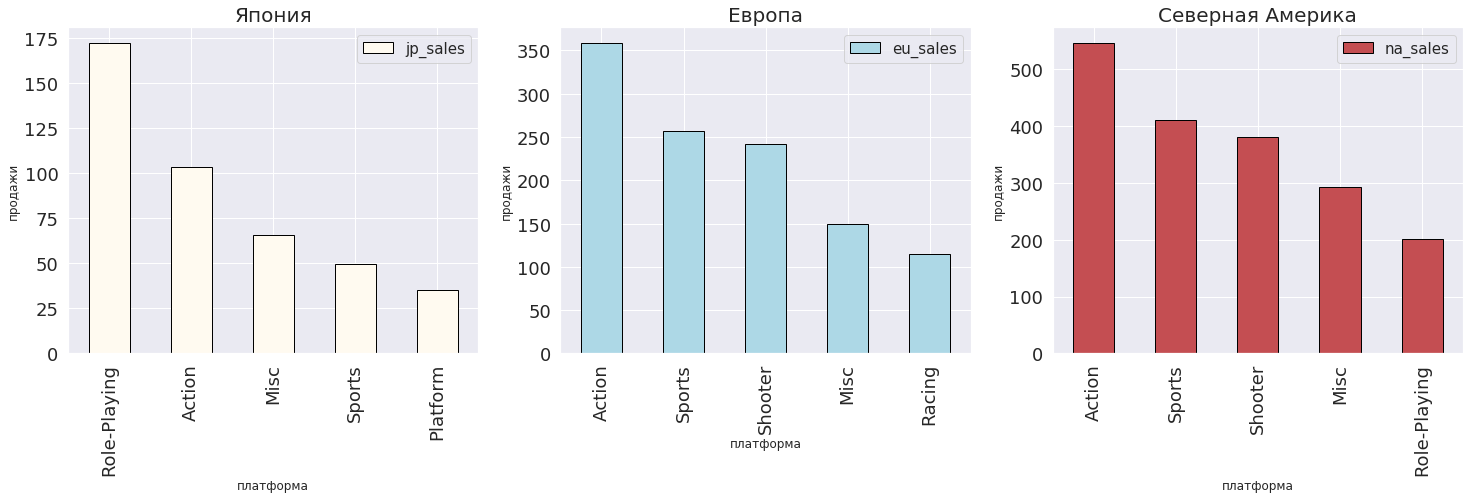

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_regions('genre', 'na_sales', 2)
top_regions('genre', 'eu_sales', 1)
top_regions('genre', 'jp_sales', 0)

Северная Америка и Европы: топ-5 для обоих регионов практически одинаковый: Action, Sports, Shooter, Misc. Единственное различие в 4 позиции. Америка предпочитает платформеры. Европа - гонки

Япония снова отличилась местной "фишкой". JRPG - топ 1 с большим отрывом

**4.3 ESRB-rating**

Изначально хотел заполнить NaNы по ESRB значением "No ESRB", но дойдя до этого пункта удалил код, отвечающий за это, тк No_ESRB портило картину и была фактически топ-2 по регионам. Все равно пришлось бы фильтровать и делать срез.

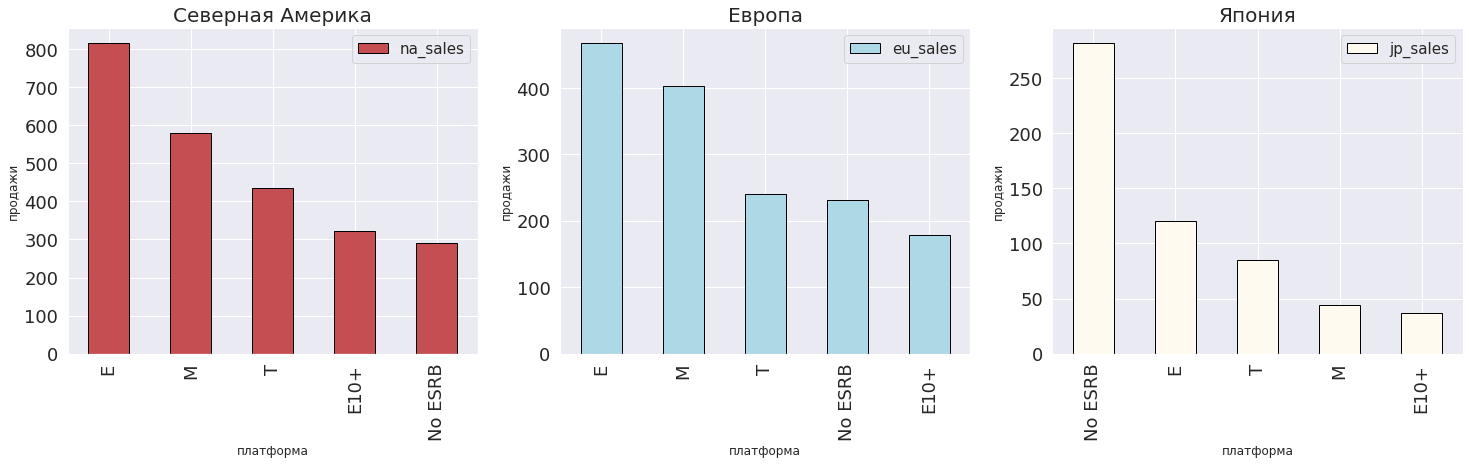

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_regions('rating', 'na_sales', 0)
top_regions('rating', 'eu_sales', 1)
top_regions('rating', 'jp_sales', 2)

Картина примерно одинаковая:

Е - игры для всех, Т > 17 лет, M от 13 до 19 лет. Пожалуй только в Японии возраст игроков поменьше чем в Америке и Европе.

**5. Проверка гипотез:**

Гипотезы:

средние пользовательские рейтинги платформ Xbox One и PC одинаковые


средние пользовательские рейтинги жанров Action и Sports разные



**5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

Выборки независимые, а значит используем t-критерий Стьюдента. Alpha = 0.05

Н0 (нулевая гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.


Н1 (альтернативная гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC отличаются между собой.

In [46]:
xbox_one = games2006_2016[(games2006_2016['platform'] == 'XOne') & (games2006_2016['user_score'] > 0)]['user_score']
pc = games2006_2016[(games2006_2016['platform'] == 'PC') & (games2006_2016['user_score'] > 0)]['user_score']
stat, p = ttest_ind(xbox_one, pc)

print('t = {}\np-value = {:.10e}'.format(stat, p))
print('alpha = 0.05')

t = -2.4745406407802504
p-value = 1.3544530125e-02
alpha = 0.05


Cредние пользовательские рейтинги платформ Xbox One и PC отличаются между собой. Отвергаем Н0.

In [47]:
print('Средняя оценка пользователей игр для платформы Xbox One  - {:.2f}'.format(xbox_one.median()))
print('Средняя оценка пользователей игр для платформы PC - {:.2f}'.format(pc.median()))

Средняя оценка пользователей игр для платформы Xbox One  - 6.80
Средняя оценка пользователей игр для платформы PC - 7.30


Краем уха слышал что у Xbox есть проблемы с приставками. Игры для PC оцениваются выше

**5.2 средние пользовательские рейтинги жанров Action и Sports разные:**

Н0 (нулевая гипотеза) - средние пользовательские рейтинги жанров Action и Sports одинаковые.
Н1 (альтернативная гипотеза) - средние пользовательские рейтинги жанров Action и Sports отличаются между собой.

In [48]:
action = games2006_2016[(games2006_2016['genre'] == 'Action') & (games['user_score'] > 0)]['user_score']
pc2 = games2006_2016[(games2006_2016['genre'] == 'Sports') & (games['user_score'] > 0)]['user_score']
stat, p = ttest_ind(action, pc2)

print('t = {}\np-value = {:.4f}'.format(stat, p))
print('alpha = 0.05')

t = 6.274113980330235
p-value = 0.0000
alpha = 0.05


Средние пользовательские рейтинги жанров Action и Sports одинаковые. Н0 - не отвергаем.

**6. Вывод:**

**В большинстве случаев самую сильную оценку на прибыль оказывают критики. Это видно из матрицы коореляции по общему датафрейму (0.43) В случае по отдельным платформам возможны вариации, как например DS и Wii (0,11)**

**Медиана продаж по топовым платформа в районе 0,2-0,25 млн, что на мой взгляд не сильно много. Выделяется консоль DS - ее медиана заметно меншье. Но тут я думаю дело в себестоимости, т.к. DS - штука карманная**

**Японцы предпочитают компактные мобильные приставки (DS) вместо десктопов. Северная Америка и Европа наоборот. Америка и Япония отдают предпочтения местным корпорациям. Xbox и DS соответственно. Европа же, ввиду отсутствия своего гиганта, предпочитает Японских производителей. Вернее даже одного: Play Station разных поколений от Sony**

**Япония страна особенная и в плане анализа данного датафрейма. В отличии от остального мира играют в основном в j-rpg, причем играть начинают раньше**.

**Так же к концу 2016 года заметно падение рынка продаж традиционных консолей. Скорее всего, связано это с развитием мобильных технологий. Очень много игр и их клонов перекочевали именно на смартфоны.**